In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "models":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging
from pathlib import Path

import numpy as np
import polars as pl

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import prepare_data
from src.models.main import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_performance_per_participant import (
    analyze_per_participant,
    plot_participant_performance,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials

13:50:19 | INFO    | utils | Using device: mps
13:50:19 | INFO    | utils | Set seed to 42


polars.config.Config

In [3]:
model, features = load_model(
    "results/experiment_eda_phasic_eda_tonic_heartrate_pupil_mean/model/PatchTST_20250429-141311.pt",
    device="cpu",  # only for inference
)

13:50:19 | INFO    | utils | Loaded PatchTST model with test accuracy 0.77% to cpu.
13:50:19 | INFO    | utils | Input shape: (50, 4) | Features: ['eda_phasic', 'eda_tonic', 'heartrate', 'pupil_mean']


In [4]:
# Load data from database
db = DatabaseManager()
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

# Prepare data
X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df, features, 5000, RANDOM_SEED
)

train_val_loader, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)


13:50:19 | INFO    | data_preparation | Number of unique participants in training set: 24
13:50:19 | INFO    | data_preparation | Number of unique participants in validation set: 9
13:50:19 | INFO    | data_preparation | Number of unique participants in test set: 9
13:50:19 | DEBUG   | data_preparation | Participant IDs in test set: [ 7 11 17 24 30 33 36 37 48]
13:50:19 | DEBUG   | data_loader | Dataset summary: Train: 2220 samples, Test: 606 samples | Input shape: (2220, 50, 4), Label shape: (2220, 2)


In [5]:
test_groups = prepare_data(
    df, features, 5000, RANDOM_SEED, only_return_test_groups=True
)

In [6]:
results_df = analyze_per_participant(
    model,
    X_test,
    y_test,
    test_groups,
    batch_size=64,
    threshold=0.5,
    pseudonymize=True,
)

# Display results
print(results_df)


shape: (10, 5)
┌─────────────┬──────────┬─────────┬───────────────┬───────────────┐
│ participant ┆ accuracy ┆ samples ┆ class_0_count ┆ class_1_count │
│ ---         ┆ ---      ┆ ---     ┆ ---           ┆ ---           │
│ str         ┆ f64      ┆ i64     ┆ i64           ┆ i64           │
╞═════════════╪══════════╪═════════╪═══════════════╪═══════════════╡
│ 1           ┆ 0.916667 ┆ 72      ┆ 36            ┆ 36            │
│ 2           ┆ 0.819444 ┆ 72      ┆ 36            ┆ 36            │
│ 3           ┆ 0.666667 ┆ 72      ┆ 36            ┆ 36            │
│ 4           ┆ 0.694444 ┆ 72      ┆ 36            ┆ 36            │
│ 5           ┆ 0.583333 ┆ 72      ┆ 36            ┆ 36            │
│ 6           ┆ 0.888889 ┆ 36      ┆ 18            ┆ 18            │
│ 7           ┆ 0.878788 ┆ 66      ┆ 33            ┆ 33            │
│ 8           ┆ 0.75     ┆ 72      ┆ 36            ┆ 36            │
│ 9           ┆ 0.833333 ┆ 72      ┆ 36            ┆ 36            │
│ overall     ┆ 0.7

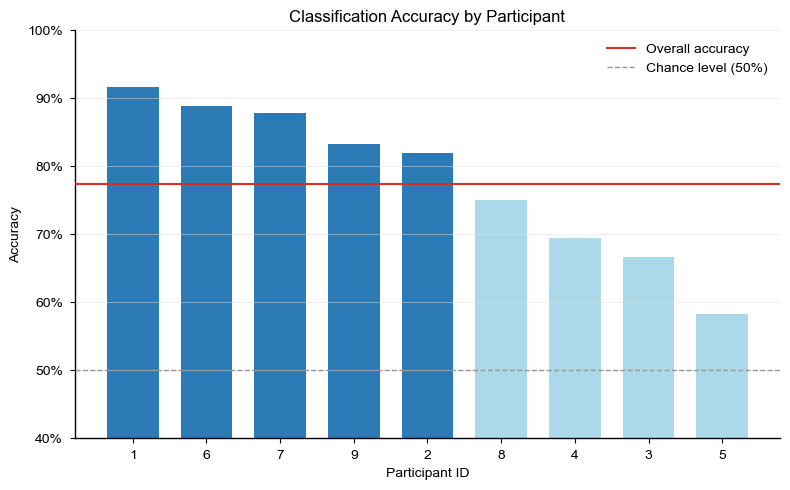

In [9]:
plot_participant_performance(results_df)

In [8]:
# Extract overall accuracy and create a DataFrame without the overall row
overall_row = results_df.filter(pl.col("participant") == "overall")
overall_accuracy = overall_row["accuracy"][0]
participants_df = results_df.filter(pl.col("participant") != "overall")

# Generate the table with cleaner code
stat_df = pl.DataFrame(
    {
        "Measure": [
            "Overall accuracy",
            "Participants above chance level",
            "Participants above overall accuracy",
            "Highest accuracy (Participant ID)",
            "Lowest accuracy (Participant ID)",
        ],
        "Value": [
            f"{overall_accuracy:.1%}",
            f"{participants_df.filter(pl.col('accuracy') > 0.5).height} out of {participants_df.height}",
            f"{participants_df.filter(pl.col('accuracy') > overall_accuracy).height} out of {participants_df.height}",
            f"{participants_df['accuracy'].max():.1%} (ID: {participants_df.filter(pl.col('accuracy') == participants_df['accuracy'].max())['participant'][0]})",
            f"{participants_df['accuracy'].min():.1%} (ID: {participants_df.filter(pl.col('accuracy') == participants_df['accuracy'].min())['participant'][0]})",
        ],
    }
)

print("Table 1: Summary of classification accuracy across participants")
print(stat_df)

Table 1: Summary of classification accuracy across participants
shape: (5, 2)
┌─────────────────────────────────┬───────────────┐
│ Measure                         ┆ Value         │
│ ---                             ┆ ---           │
│ str                             ┆ str           │
╞═════════════════════════════════╪═══════════════╡
│ Overall accuracy                ┆ 77.4%         │
│ Participants above chance leve… ┆ 9 out of 9    │
│ Participants above overall acc… ┆ 5 out of 9    │
│ Highest accuracy (Participant … ┆ 91.7% (ID: 1) │
│ Lowest accuracy (Participant I… ┆ 58.3% (ID: 5) │
└─────────────────────────────────┴───────────────┘
